In [49]:
import intake
import xarray as xr

from netCDF4 import default_fillvals

import regrid_tools
import pop_tools

In [50]:
cat = intake.open_catalog('catalogs/fgco2_MPI-SOM-FFN.yml')
cat

fgco2_MPI-SOM-FFN:
  args:
    path: catalogs/fgco2_MPI-SOM-FFN.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [51]:
ds = cat.fgco2_MPI_SOM_FFN().to_dask().compute()
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, lat: 180, lon: 360, time: 432)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables: (12/14)
    spco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    sol             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    kw              (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...              ...
    dco2_raw        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    dco2_smoothed   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    seamask         (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    time_bnds       (time, bnds) datetime64[ns] 1981-12-31 ... 2017-12-31
    lat_bnds        (lat, bnds) float32 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds        (lon, bnds) float32 -180.0 -179.0 -179.0 ... 179.0 180.0
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

In [52]:
dst_grid = regrid_tools.grid('POP_gx1v7', clobber=False)
src_grid = regrid_tools.grid('latlon_woa2018', nx=360, ny=180, lon0=-180.)

regridder = regrid_tools.regridder(src_grid, dst_grid, 'conserve', clobber=False)
dso_model = xr.Dataset()
dso_model = regridder.regrid(ds[['fgco2_raw', 'fgco2_smoothed']], renormalize=True, apply_mask=True,).rename({'lat': 'nlat', 'lon': 'nlon'})


for v in dso_model.data_vars:
    del dso_model[v].attrs['FillValue']
    dso_model[v].encoding['coordinates'] = 'TLONG TLAT time'
    dso_model[v].encoding['_FillValue'] = default_fillvals['f8'] 

    
ds_grid = pop_tools.get_grid('POP_gx1v7')
for v in ds_grid.variables:
    dso_model[v] = ds_grid[v]    
dso_model  

exists: /glade/work/mclong/adhoc-regridding/POP_gx1v7.nc
exists: /glade/work/mclong/adhoc-regridding/latlon_woa2018.nc
source grid dims: (180, 360)
destination grid dims: (384, 320)


<xarray.Dataset>
Dimensions:         (nlat: 384, nlon: 320, nreg: 13, time: 432, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
  * z_t             (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w             (z_w) float64 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot         (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
  * nreg            (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/17)
    fgco2_raw       (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    fgco2_smoothed  (time, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    TLAT            (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.19 72.19
    TLONG           (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT            (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.41 72.41
    ULONG           (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ...              ...
    UAREA           (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT             (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    REGION_MASK     (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    dz              (z_t) float64 1e+03 1e+03 1e+03 ... 2.5e+04 2.5e+04
    region_name     (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val      (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

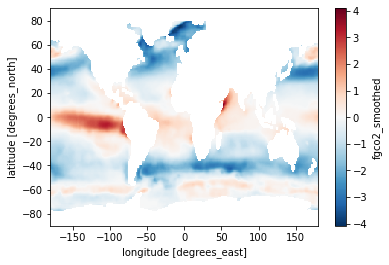

In [53]:
ds.fgco2_smoothed.mean('time').plot()

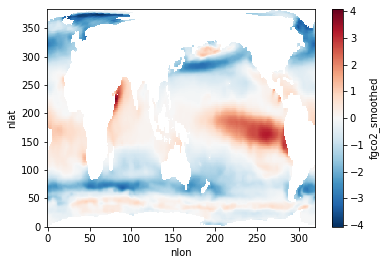

In [54]:
dso_model.fgco2_smoothed.mean('time').plot()

In [55]:
dso_model.to_netcdf('/glade/p/cgd/oce/projects/cesm2-marbl/fgco2-MPI-SOM-FFN_POP_gx1v7.nc')

In [56]:
!ncdump -h /glade/p/cgd/oce/projects/cesm2-marbl/fgco2-MPI-SOM-FFN_POP_gx1v7.nc

netcdf fgco2-MPI-SOM-FFN_POP_gx1v7 {
dimensions:
	time = 432 ;
	nlat = 384 ;
	nlon = 320 ;
	z_t = 60 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	nreg = 13 ;
variables:
	int time(time) ;
		time:bounds = "time_bnds" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2000-01-01" ;
		time:calendar = "proleptic_gregorian" ;
	double fgco2_raw(time, nlat, nlon) ;
		fgco2_raw:_FillValue = 9.96920996838687e+36 ;
		fgco2_raw:long_name = "CO2 flux density" ;
		fgco2_raw:standard_name = "CO2 flux density" ;
		fgco2_raw:units = "mol m^{-2} yr^{-1}" ;
		fgco2_raw:coordinates = "TLONG TLAT time" ;
	double fgco2_smoothed(time, nlat, nlon) ;
		fgco2_smoothed:_FillValue = 9.96920996838687e+36 ;
		fgco2_smoothed:long_name = "CO2 flux density smoothed" ;
		fgco2_smoothed:standard_name = "CO2 flux density smoothed" ;
		fgco2_smoothed:units = "mol m^{-2} yr^{-1}" ;
		fgco2_smoothed:coordinates = "TLONG TLAT time" ;
	double TLAT(nlat, nlon) ;
		TLAT:_FillValue = NaN ;
		TLAT:units